# Simuating  Montbrio Model (Numpy/Scipy/Torch/Jax)

In [1]:
import os
import sys
import time
import timeit
from tqdm import tqdm

import numpy as np
import scipy as snp
import numba, torch, jax

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%pylab inline

plt.style.use('seaborn-talk');
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [6]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Jax version: {jax.__version__}")

Numpy version: 1.24.4
Numba version: 0.57.1
Torch version: 2.0.1+cu117
Jax version: 0.4.13


 Numpy version: 1.19.5
Numba version: 0.53.1
Torch version: 1.8.0
Jax version: 0.1.73

#  Montbrio model

$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $



### Numpy/Numba Jit

In [7]:
import numba
from numba import jit, njit

In [8]:
def Montbrio_model_numpy(v0, r0, delta, eta, J, I_input, dt, sigma):
    
    nsteps=len(I_input)
    r, v= np.zeros(nsteps), np.zeros(nsteps)
    
    v_init, r_init=v0, r0
    v[0],r[0]=v_init, r_init
    
    for i in range(1, nsteps):
        dr =(delta/np.pi) +2*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        r[i]=(r[i-1] + dt * dr +np.sqrt(dt) *sigma * np.random.randn())
        v[i]=(v[i-1] + dt * dv +np.sqrt(dt) *sigma * np.random.randn())    
    
    return v, r

In [9]:
Montbrio_model_numba = numba.jit(Montbrio_model_numpy)

In [10]:
#set the model parameters
delta=0.7
eta=-4.6
J=14.5
sigma=0.0

In [11]:
#setup for simulation
dt = 0.001
t_init = 0.0
t_final = 100.0
ts = np.arange(t_init,t_final,dt)
nsteps = int((t_final - t_init)/dt)

In [12]:
# Input current
I0=3.
t0In=30
tn_In=60

I_input = np.concatenate((
    np.zeros(int((t0In - t_init) / dt)),
    np.full(int((tn_In - t0In) / dt), I0),
    np.zeros(int((t_final - tn_In) / dt))
))

In [13]:
#initial condition
v0 = -3.
r0 = .5

In [14]:
start_time = time.time()

v_numpy,r_numpy = Montbrio_model_numpy(v0, r0, delta, eta, J, I_input, dt, sigma)

print("---numpy took: %s seconds took in python  ---" % (time.time() - start_time))

---numpy took: 0.564507007598877 seconds took in python  ---


In [15]:
start_time = time.time()

v_numba,r_numba= Montbrio_model_numba(v0, r0, delta, eta, J, I_input, dt, sigma)

print("---numpy first compile took: %s seconds took compiled by JIT ---" % (time.time() - start_time))

---numpy first compile took: 1.1162652969360352 seconds took compiled by JIT ---


In [16]:
start_time = time.time()

v_numba,r_numba = Montbrio_model_numba(v0, r0, delta, eta, J, I_input, dt, sigma)

print("---numpy took: %s seconds took by JIT ---" % (time.time() - start_time))

---numpy took: 0.009798288345336914 seconds took by JIT ---


In [17]:
num_sims=10

In [18]:
start_time = time.time()

with tqdm(range(num_sims), unit='epoch') as tq:
    for epoch in tq:
        v,r = Montbrio_model_numba(v0, r0, delta, eta, J, I_input, dt, sigma)
        
print("---%s seconds took for 10 simuations in JIT  ---" % (time.time() - start_time))


100%|███████████████████████████████████████| 10/10 [00:00<00:00, 121.69epoch/s]

---0.08589339256286621 seconds took for 10 simuations in JIT  ---


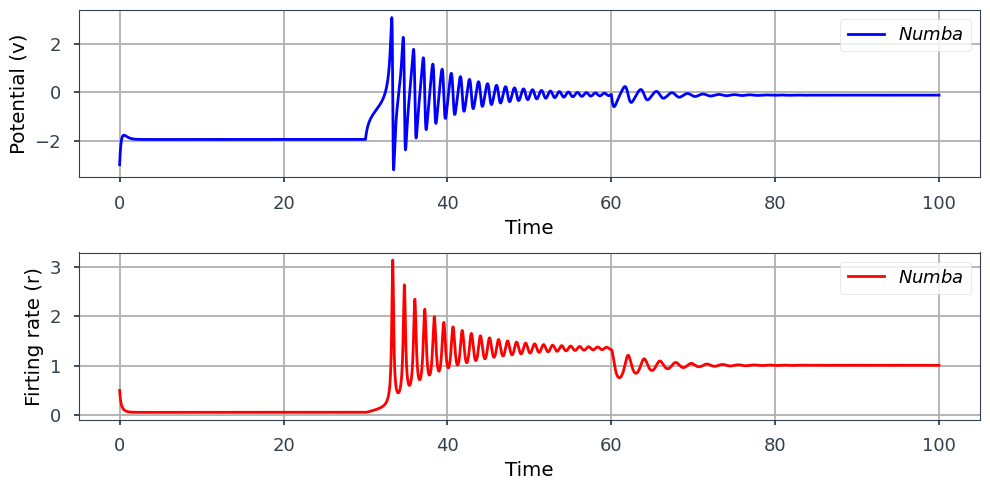

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(ts, v_numba, 'b', linewidth=2, label='$Numba$')
plt.xlabel('Time'); plt.ylabel('Potential (v)'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_numba, 'r', linewidth=2, label='$Numba$')
plt.xlabel('Time'); plt.ylabel('Firting rate (r)'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()

### scipy

In [20]:
from scipy.integrate import odeint

In [21]:
def Montbrio(x, t, delta, eta, J):

    """Time derivative of the Montbrio neural model.
    Args:
    x (array size 2): [Membrane potential, Recovery variable]
    delta, eta, J (float): Parameters.
    t (float): Time (Not used: autonomous system)
    Return: dx/dt (array size 2)

    """

    return np.array([ x[0]**2 - (np.pi*x[1])**2 + J*x[1] +eta+Current(t), 
                     (delta/np.pi) + 2*x[1]*x[0]])

In [22]:
def Current(t):
    I0 = 3.0 # Amplitude of the input
    t_init = 0.0 # Initial time
    t0In = 30.0 # Time to start input
    tn_In = 60.0 # Time to end input
    t_final = 100.0 # Final time
    if t_init <= t < t0In:
         return 0.0
    elif t0In <= t < tn_In:
         return I0
    elif tn_In <= t <= t_final:
         return 0.0
    else:
         return 0.0 

In [23]:

start_time = time.time()

sol_sci = odeint(Montbrio, [v0,r0], ts, args=(delta, eta, J))

print("---scipy took:  %s seconds ---" % (time.time() - start_time))

---scipy took:  0.05313873291015625 seconds ---


In [24]:
start_time = time.time()

with tqdm(range(num_sims), unit='epoch') as tq:
    for epoch in tq:
        vr = odeint(Montbrio, [v0,r0], ts, args=(delta, eta, J))
        
print("---%s seconds took for 10 simuations in Scipy odeint ---" % (time.time() - start_time))


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 32.65epoch/s]

---0.3093700408935547 seconds took for 10 simuations in Scipy odeint ---


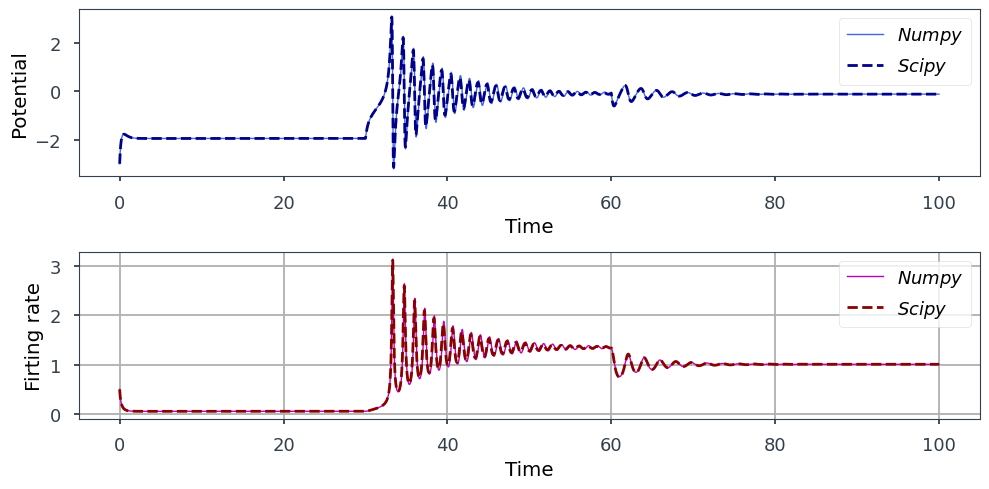

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(ts, v_numba, 'royalblue', linewidth=1, label='$Numpy$')
plt.plot(ts, sol_sci[:,0], linestyle='--',  color='darkblue', linewidth=2, label='$Scipy$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.grid

plt.subplot(212)
plt.plot(ts, r_numba, 'm', linewidth=1, label='$Numpy$')
plt.plot(ts, sol_sci[:,1], linestyle='--', color= 'darkred', linewidth=2, label='$Scipy$')
plt.xlabel('Time'); plt.ylabel('Firting rate'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()

### Torch

In [26]:
import torch
import torch.nn.functional as F

In [27]:
torch.set_num_threads(8)

In [28]:
def Montbrio_model_pytorch(v0, r0, delta, eta, J, I_input, dt, sigma):
    
    nsteps = len(I_input)
    r, v = torch.zeros(nsteps), torch.zeros(nsteps)
    
    v_init, r_init = v0, r0
    v[0], r[0] = v_init, r_init
    
    for i in range(1, nsteps):
        dr = (delta / np.pi) + 2 * r[i-1] * v[i-1]
        dv = v[i-1]**2 - (np.pi * r[i-1])**2 + J * r[i-1] + eta + I_input[i-1]
        r[i] = r[i-1] + dt * dr + torch.sqrt(torch.tensor(dt)) * sigma * torch.randn(())
        v[i] = v[i-1] + dt * dv + torch.sqrt(torch.tensor(dt)) * sigma * torch.randn(())
    
    return torch.cat([v, r], dim=0)

In [29]:
start_time = time.time()

sol_pytorch= Montbrio_model_pytorch(v0, r0, delta, eta, J, I_input, dt, sigma)

print("---Pytorch took  %s seconds took in Pytorch ---" % (time.time() - start_time))

---Pytorch took  17.933704614639282 seconds took in Pytorch ---


In [30]:
start_time = time.time()

with tqdm(range(num_sims), unit='epoch') as tq:
    for epoch in tq:
        vr= Montbrio_model_pytorch(v0, r0, delta, eta, J, I_input, dt, sigma)
        
print("--- %s seconds took for 10 simuations in Pytorch ---" % (time.time() - start_time))


100%|████████████████████████████████████████| 10/10 [02:58<00:00, 17.89s/epoch]

--- 178.92959117889404 seconds took for 10 simuations in Pytorch ---


In [31]:
def Montbrio_model_pytorch_dev(v0, r0, delta, eta, J, I_input, dt, sigma):
    nsteps = len(I_input)
    r = torch.zeros(nsteps, device=device)
    v = torch.zeros(nsteps, device=device)
    
    v[0] = v0
    r[0] = r0
    
    for i in range(1, nsteps):
        dr = (delta / np.pi) + 2 * r[i-1] * v[i-1]
        dv = v[i-1]**2 - (np.pi * r[i-1])**2 + J * r[i-1] + eta + I_input[i-1]
        r[i] = r[i-1] + dt * dr + torch.sqrt(torch.tensor(dt, device=device)) * sigma * torch.randn(())
        v[i] = v[i-1] + dt * dv + torch.sqrt(torch.tensor(dt, device=device)) * sigma * torch.randn(())
    
    return v.cpu().numpy(), r.cpu().numpy()

if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")   

In [32]:
I_input = torch.tensor(I_input, device=device)

In [33]:
start_time = time.time()

sol_pytorch = Montbrio_model_pytorch_dev(v0, r0, delta, eta, J, I_input, dt, sigma)

print("--- %s seconds took in Pytorch ---" % (time.time() - start_time))

--- 18.32479476928711 seconds took in Pytorch ---


In [34]:
v_pytorch, r_pytorch=sol_pytorch[0], sol_pytorch[1]

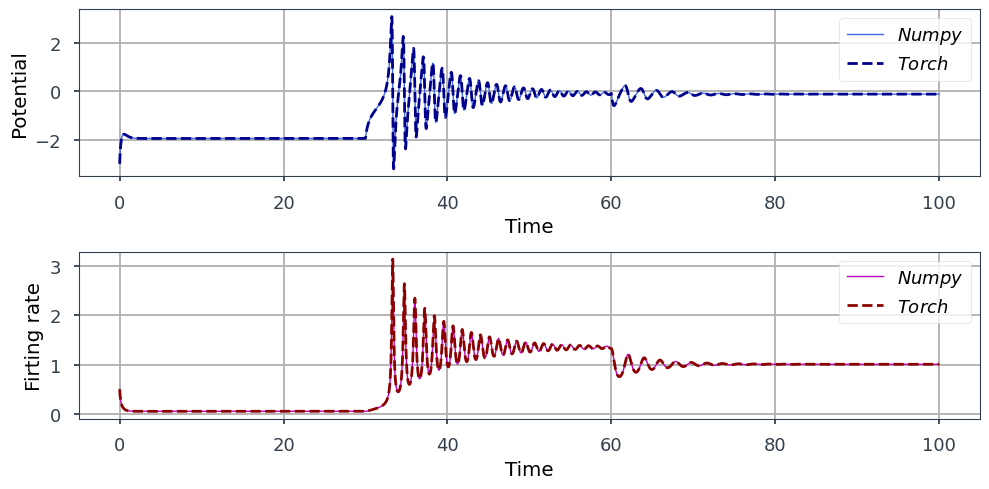

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(ts, v_numba, 'royalblue', linewidth=1, label='$Numpy$')
plt.plot(ts, v_pytorch, linestyle='--',  color='darkblue', linewidth=2, label='$Torch$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(212)
plt.plot(ts, r_numba, 'm', linewidth=1, label='$Numpy$')
plt.plot(ts, r_pytorch, linestyle='--', color= 'darkred', linewidth=2, label='$Torch$')
plt.xlabel('Time'); plt.ylabel('Firting rate'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()

In [36]:
import torch.nn as nn
from torchdiffeq import odeint as odeint
from torchdiffeq import odeint_adjoint as odeint

In [37]:
class MPR(nn.Module):
    """
    Montbrio model.
    """
    def __init__(self,
                 delta: float = 0.7,
                 eta: float = -4.6,
                 J: float = 14.5,
                 sigma: float = 10 
                 ):
        super().__init__()
        # learnable parameters
        self.model_params = torch.nn.Parameter(torch.tensor([delta, eta, J, sigma]))

    def forward(self,
                t: float, # time index
                state: torch.TensorType, # state of the system first dimension is the batch size,
                ) -> torch.Tensor: # return the derivative of the state
        """
            Define the right hand side of the Montbrio model.
        """
        delta, eta, J, sigma = self.model_params
        v = state[..., 0] # first dimension is the batch size
        r = state[..., 1]
        
        sqrt_dt = torch.sqrt(torch.tensor(dt))
        random_tensor = torch.randn(())  
        
        dr = delta / np.pi + 2 * r * v+sqrt_dt * sigma * random_tensor
        dv = v*v + eta + J * r - np.pi*np.pi*r*r + sqrt_dt * sigma * random_tensor+ torch.tensor([3.0 if t >= 30 and t <=60 else 0.]).float()
        
        sol = torch.zeros_like(state)
        sol[..., 0] = dv
        sol[..., 1] = dr
        return sol

    def __repr__(self):
        """Print the parameters of the model."""
        return f" delta: {self.model_params[0].item()}, \
            eta: {self.model_params[1].item()}, \
              J: {self.model_params[2].item()}, \
                sigma: {self.model_params[3].item()}"



In [38]:
MPR_model = MPR()

In [39]:
MPR_model = MPR(delta=0.7, eta=-4.6, J=14.5, sigma=0.)

In [40]:
ts = torch.linspace(0,100.0,nsteps) 
ts.shape

torch.Size([100000])

In [41]:
batch_size = 1
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[v0,r0]]) + 0.1*torch.randn((batch_size,2))

In [42]:
initial_conditions.shape

torch.Size([1, 2])

In [43]:
start_time = time.time()

sol_euler = odeint(MPR_model, initial_conditions, ts, method='euler', options={'step_size':0.001}).detach().numpy()

print("--- %s seconds took in torchdiffeq and Euler ---" % (time.time() - start_time))

--- 24.425455808639526 seconds took in torchdiffeq and Euler ---


In [44]:
start_time = time.time()

sol_rk4 = odeint(MPR_model, initial_conditions, ts,  method='rk4').detach().numpy()

print("--- %s seconds took in torchdiffeq and RK4 ---" % (time.time() - start_time))

--- 82.6154956817627 seconds took in torchdiffeq and RK4 ---


In [45]:
start_time = time.time()

sol_dopri5 = odeint(MPR_model, initial_conditions, ts, method='dopri5').detach().numpy()

print("--- %s seconds took in torchdiffeq and RK5 ---" % (time.time() - start_time))

--- 10.735829591751099 seconds took in torchdiffeq and RK5 ---


In [46]:
sol_euler.shape, sol_rk4.shape, sol_dopri5.shape, 

((100000, 1, 2), (100000, 1, 2), (100000, 1, 2))

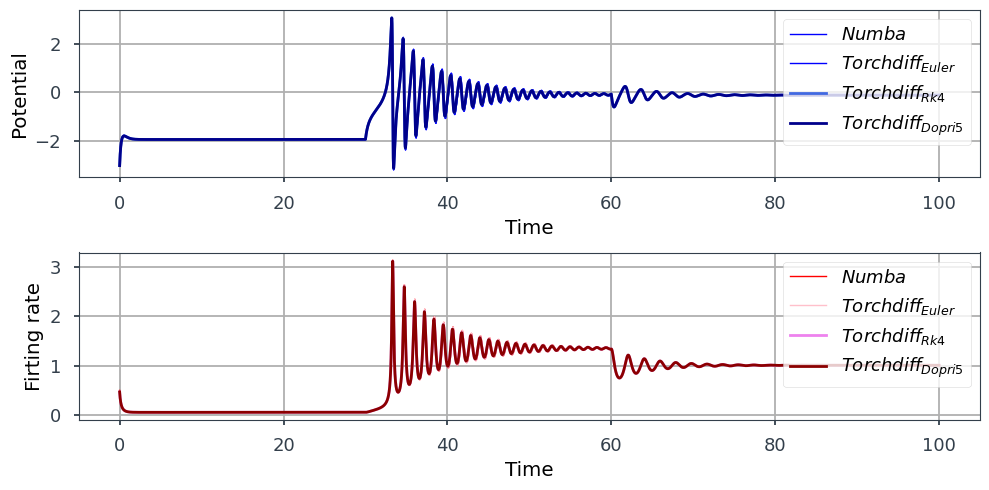

In [47]:
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(ts, v_numba, 'b', linewidth=1, label='$Numba$')
plt.plot(ts, sol_euler[:, 0, 0], 'blue', linewidth=1, label='$Torchdiff_{Euler}$')
plt.plot(ts, sol_rk4[:, 0, 0], 'royalblue', linewidth=2, label='$Torchdiff_{Rk4}$')
plt.plot(ts, sol_dopri5[:, 0, 0], 'darkblue', linewidth=2, label='$Torchdiff_{Dopri5}$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(212)
plt.plot(ts, r_numba, 'red', linewidth=1, label='$Numba$')
plt.plot(ts, sol_euler[:, 0, 1], 'pink', linewidth=1, label='$Torchdiff_{Euler}$')
plt.plot(ts, sol_rk4[:, 0, 1], 'violet', linewidth=2, label='$Torchdiff_{Rk4}$')
plt.plot(ts, sol_dopri5[:, 0, 1], 'darkred', linewidth=2, label='$Torchdiff_{Dopri5}$')
plt.xlabel('Time'); plt.ylabel('Firting rate'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()

### JAX

In [48]:
import jax
import jax.numpy as jnp
from jax import jit, lax, random

In [49]:
def Montbrio_model_jax(v0, r0, delta, eta, J, I_input, dt, sigma):
    key = jax.random.PRNGKey(0)
    def update(carry, i):
        r, v = carry
        dr = (delta / jnp.pi) + 2 * r * v
        dv = v**2 - (jnp.pi * r)**2 + J * r + eta + I_input[i]
        r = r + dt * dr + jnp.sqrt(dt) * sigma * random.normal(key=key)
        v = v + dt * dv + jnp.sqrt(dt) * sigma * random.normal(key=key)
        return (r, v), (r, v)

    nsteps = len(I_input)
    init_carry = (r0, v0)
    _, (r, v) = lax.scan(update, init_carry, jnp.arange(nsteps))
    
    return v, r

I_input = jnp.concatenate((
    jnp.zeros(int((t0In - t_init) / dt)),
    jnp.full(int((tn_In - t0In) / dt), I0),
    jnp.zeros(int((t_final - tn_In) / dt))
))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [50]:
start_time = time.time()

v_jax, r_jax = Montbrio_model_jax(v0, r0, delta, eta, J, I_input, dt, sigma)

print("--- %s seconds took in jax ---" % (time.time() - start_time))

--- 0.24344682693481445 seconds took in jax ---


In [51]:
start_time = time.time()

with tqdm(range(num_sims), unit='epoch') as tq:
    for epoch in tq:
         v, r = Montbrio_model_jax(v0, r0, delta, eta, J, I_input, dt, sigma)
        
print("--- %s seconds took for 10 simuations in jax  ---" % (time.time() - start_time))

100%|████████████████████████████████████████| 10/10 [00:01<00:00,  5.34epoch/s]

--- 1.8752601146697998 seconds took for 10 simuations in jax  ---


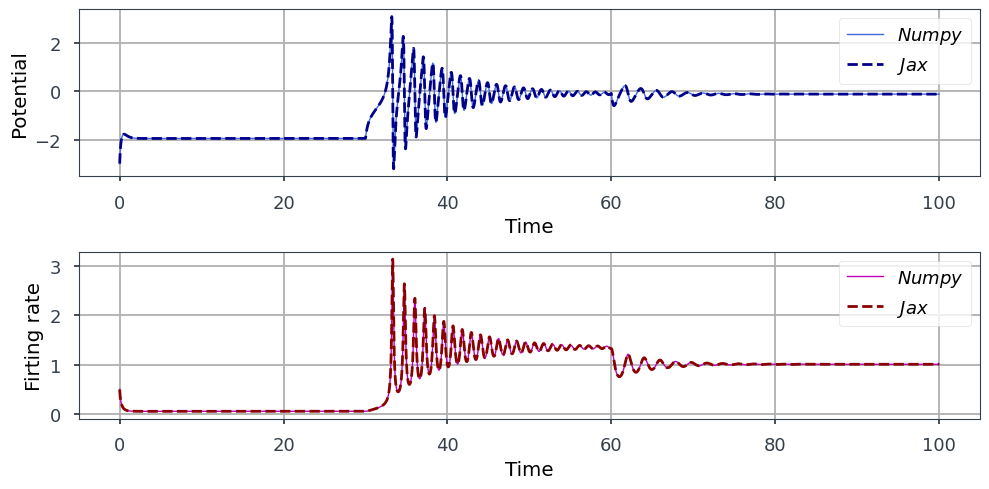

In [52]:
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(ts, v_numba, 'royalblue', linewidth=1, label='$Numpy$')
plt.plot(ts, v_jax, linestyle='--',  color='darkblue', linewidth=2, label='$Jax$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(212)
plt.plot(ts, r_numba, 'm', linewidth=1, label='$Numpy$')
plt.plot(ts, r_jax, linestyle='--', color= 'darkred', linewidth=2, label='$Jax$')
plt.xlabel('Time'); plt.ylabel('Firting rate'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()

In [53]:
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Kvaerno5, PIDController

In [54]:
def MPR_vector_field(t, y, args):
    r, v = y
    delta, eta, J, sigma = args
     
    dr = delta / np.pi + 2 * r * v
    dv = v*v + eta + J * r - np.pi*np.pi*r*r 

    dy = dv, dr
    return dy

In [55]:
term = ODETerm(MPR_vector_field)
solver =   Kvaerno5()
y0 = (v0, r0)
args = (delta,eta,J, sigma)
saveat = SaveAt(ts=jnp.linspace(t_init, t_final, nsteps), dense=True)

In [56]:
stepsize_controller = PIDController(rtol=1e-9, atol=1e-9)

In [57]:
# start_time = time.time()

# sol = diffeqsolve(term, solver, t_init, t_final, dt, y0, args=args, saveat=saveat, stepsize_controller=stepsize_controller, max_steps = 100000)

# print("--- %s seconds ---" % (time.time() - start_time))

In [58]:
# def Montbrio(x, t, delta, eta, J, I0):
#     """Time derivative of the Montbrio neural model.
#     Args:
#        x (array size 2): [Membrane potential, Recovery variable]
#        delta, eta, J (float): Parameters.
#        t (float): Time (Not used: autonomous system)
#     Return: dx/dt (array size 2)
#     """
#     return np.array([(delta/np.pi) + 2*x[0]*x[1], 
#                      x[1]**2 - (np.pi*x[0])**2 + J*x[0] + eta+Current(t)])


# def Current(t):
#         I0 = 3.0  # Amplitude of the input
#         t_init = 0.0  # Initial time
#         t0In = 30.0  # Time to start input
#         tn_In = 60.0  # Time to end input
#         t_final = 100.0  # Final time

#         if t_init <= t < t0In:
#             return 0.0
#         elif t0In <= t < tn_In:
#             return I0
#         elif tn_In <= t <= t_final:
#             return 0.0
#         else:
#             return 0.0  
        
# tspan=np.linspace(0,100, 100000)
# from scipy.integrate import odeint
# y = odeint(Montbrio, [0.5,-3], tspan, args=(delta, eta, J, I0))        